In [8]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pygame as pg
from sklearn.decomposition import PCA, KernelPCA
import umap

In [9]:
filename = "bitch lasagna.wav"
sound_data, sampling_rate = librosa.load(filename)

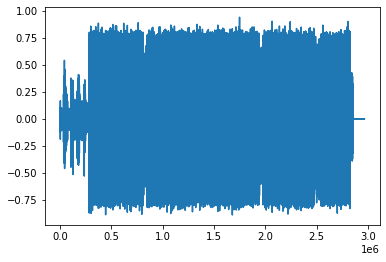

In [10]:
#sound_data = sound_data[:-10*sampling_rate]
plt.plot(sound_data)

In [11]:
sound_data.shape[0]/sampling_rate
samples_per_frame = int(sampling_rate/3)

<ipython-input-12-8215ae843f46>:9: RuntimeWarning: divide by zero encountered in log10
  Xdb = 20*np.log10(np.abs(X))


48.11544353098732
fitting pca


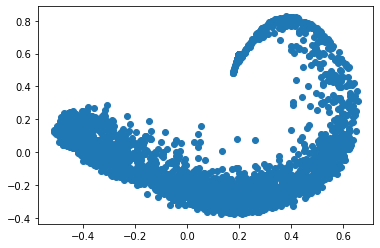

In [12]:
x, fs = sound_data, sampling_rate
N = int((1/30)*fs)    # four seconds of audio
samples_per_frame = N

frequency_samples = []
max_db = 0
for i in range(0, sound_data.shape[0]-samples_per_frame, samples_per_frame):
    X = np.fft.rfft(x[i:N+i])
    Xdb = 20*np.log10(np.abs(X))
    #Xdb = X.real
    frequency_samples.append(np.nan_to_num(Xdb, nan=0, posinf=50, neginf=-50))
frequency_samples = np.array(frequency_samples)
max_db = np.max(frequency_samples)
print(max_db)
print("fitting pca")
#pca = umap.UMAP()
pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.03)
#pca = PCA(n_components=2)
frequency_samples /= max_db
#frequency_sample_sum = np.sum(frequency_samples, axis=1)
pca.fit(frequency_samples)

transformed_samples = pca.transform(frequency_samples)

plt.scatter(transformed_samples[:,0], transformed_samples[:,1])
norm_mins = np.min(transformed_samples, axis=0)
norm_maxes = np.max(transformed_samples, axis=0)
norm_diffs = norm_maxes - norm_mins

In [13]:
pg.init()

clock = pg.time.Clock()

screen = pg.display.set_mode((600, 600))
pg.display.set_caption("FFT")

running = True

pg.mixer.music.load(filename)
pg.mixer.music.play()
smooth_circle_position = np.array([[300, 300]])
smoothness = 0.0
n_positions = 5
positions = [(300, 300)] * n_positions
while running:
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False

    music_time_millis = pg.mixer.music.get_pos()
    music_time_seconds = music_time_millis/1000
    music_time_sample_index = int(music_time_seconds*sampling_rate)
    sample = sound_data[music_time_sample_index:music_time_sample_index+samples_per_frame]
    X = np.fft.rfft(sample)
    Xdb = 20*np.log10(np.abs(X))
    #Xdb = X.real
    Xdb = np.nan_to_num(Xdb, nan=0, posinf=50, neginf=-50)
    screen.fill((0, 0, 0))
    #for frequency_strength in Xdb:
    frequency_positions = np.linspace(0, 600, Xdb.shape[0])
    for i, frequency_strength in enumerate(Xdb):
        pg.draw.line(screen, (255, 255, 255), (frequency_positions[i], 600), (frequency_positions[i], 600-frequency_strength*(600/max_db)))
    circle_position = pca.transform(np.array([Xdb])/max_db)
    circle_position = (circle_position - norm_mins)/norm_diffs
    smooth_circle_position = smoothness*smooth_circle_position + (1-smoothness)*circle_position
    #circle_position = circle_position * 600
    x, y = smooth_circle_position[0]*600
    positions.append((x, y))
    positions = positions[1:]
    # draw polyline from positions
    pg.draw.lines(screen, (255, 255, 255), False, positions, 2)
    pg.draw.circle(screen, (255, 255, 255), (600*smooth_circle_position[0, 0], 600*smooth_circle_position[0, 1]), 5)
    pg.display.update()
    clock.tick(30)
pg.mixer.music.stop()
pg.mixer.music.unload()
pg.quit()

<ipython-input-13-6df75b047bf3>:26: RuntimeWarning: divide by zero encountered in log10
  Xdb = 20*np.log10(np.abs(X))
<ipython-input-13-6df75b047bf3>:26: RuntimeWarning: divide by zero encountered in log10
  Xdb = 20*np.log10(np.abs(X))
<ipython-input-13-6df75b047bf3>:26: RuntimeWarning: divide by zero encountered in log10
  Xdb = 20*np.log10(np.abs(X))
